![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FDev&file=CPR+Endpoints+That+Train.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/CPR%20Endpoints%20That%20Train.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FDev%2FCPR%2520Endpoints%2520That%2520Train.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Dev/CPR%20Endpoints%20That%20Train.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Dev/CPR%20Endpoints%20That%20Train.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Custom Prediction Routines for Endpoints That Train

- https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines
- https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.prediction.LocalModel
- https://github.com/googleapis/python-aiplatform/blob/custom-prediction-routine/google/cloud/aiplatform/prediction/predictor.py
- https://github.com/googleapis/python-aiplatform/blob/custom-prediction-routine/google/cloud/aiplatform/prediction/sklearn/predictor.py
- https://codelabs.developers.google.com/vertex-cpr-sklearn#0
- prediction request limit is 1.5MB: https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#send_an_online_prediction_request

**TODO**
- [X] Try using storage read for BigQuery
    - https://cloud.google.com/bigquery/docs/reference/storage/libraries#client-libraries-usage-python

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [4]:
REGION = 'us-central1'
EXPERIMENT = 'cpr_training'
SERIES = '04'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

In [12]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import service_usage_v1

from datetime import datetime
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import metrics

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

In [13]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project = PROJECT_ID)

In [14]:
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
REPOSITORY = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}"
DIR = f"temp/{EXPERIMENT}"

In [15]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

In [16]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Idea: Decision Tree on Samples

- Input parameter is a sample size `n`
- Retrieve a sample of size `n` from a BigQuery table to a Pandas dataframe
- Use sklearn.tree.DecisionTreeClassifier to build a classifier
- Retrieve the rules of the tree

---
Use BigQuery Python Client (query): 
- https://cloud.google.com/python/docs/reference/bigquery/latest

In [17]:
n = 4000

In [18]:
train = bq.query(query = f"""
        SELECT * EXCEPT(splits, transaction_id)
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            WHERE splits = 'TRAIN' and RAND() < 0.1
            LIMIT {n}
        """).to_dataframe()

---
### Use BigQuery Storage API:
- https://cloud.google.com/bigquery/docs/reference/storage/libraries
- https://cloud.google.com/python/docs/reference/bigquerystorage/latest

In [20]:
from google.cloud import bigquery_storage
import concurrent.futures

In [21]:
bqstorage = bigquery_storage.BigQueryReadClient()

In [22]:
read_options = bigquery_storage.types.ReadSession.TableReadOptions(
    row_restriction = "splits = 'TEST'" 
)

In [23]:
session = bigquery_storage.types.ReadSession(
    table = f"projects/{BQ_PROJECT}/datasets/{BQ_DATASET}/tables/{BQ_TABLE}",
    data_format = bigquery_storage.types.DataFormat.ARROW,
    read_options = read_options
)

In [24]:
read_session = bqstorage.create_read_session(
    parent = f'projects/{PROJECT_ID}',
    read_session = session,
    max_stream_count = 1
)

In [25]:
len(read_session.streams)

1

If the scenario has more than one stream and they will be use async then see the follow note on [multiprocessing](https://cloud.google.com/python/docs/reference/bigquerystorage/latest/multiprocessing).

When there are multiple streams the all will need to be read to get the full set of rows.  This can be done synchronously or asynchronously using multiprocessing. To see details and an example of each approach review the [../Tips/BigQuery - Python Client](../Tips/BigQuery%20-%20Python%20Client.ipynb) notebook.

#### Read Rows
This methods works for a single stream

In [27]:
reader = bqstorage.read_rows(
    name = read_session.streams[0].name
)

In [28]:
train = reader.to_dataframe().drop(['splits', 'transaction_id'], axis = 1)

In [29]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.00,0
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.00,0
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.00,0
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.00,0
4,165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,...,0.234502,0.825237,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28497,39892,-0.886023,-3.746952,-0.013576,1.026757,-1.797836,1.264180,0.405933,0.253152,0.830121,...,0.483613,-0.649644,-0.759476,-0.179642,-0.429041,0.846207,-0.197371,0.173713,1023.22,0
28498,4462,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
28499,42801,0.340725,-1.225499,-0.745517,1.026148,0.654991,2.089517,0.296109,0.515619,-0.002562,...,0.299103,0.238042,-0.466934,-1.871375,0.447112,-0.148891,-0.000906,0.044125,383.86,0
28500,146852,-4.233290,0.378911,-5.491528,0.019751,-3.016256,-0.876330,2.924504,0.904368,-0.589821,...,0.128130,1.469656,0.245055,0.269178,-0.825780,0.729517,1.180039,-0.675639,543.72,0


---
Use sklearn.tree to make list of decision rules using data:

In [30]:
y = train[VAR_TARGET]
X = train.drop(VAR_TARGET, axis = 1)

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_leaf_nodes = 3, random_state = 0)
clf.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

In [32]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

def path_builder(node_num, path, x):
        path.append(node_num)
        if node_num == x:
            return True
        left = False
        right = False
        if (children_left[node_num] !=-1):
            left = path_builder(children_left[node_num], path, x)
        if (children_right[node_num] !=-1):
            right = path_builder(children_right[node_num], path, x)
        if left or right :
            return True
        path.remove(node_num)
        return False


def rule_builder(path, column_names):
    rule = ''
    for index, node in enumerate(path):
        if index != len(path)-1:
            if len(rule) > 0: rule += ' and '
            if (children_left[node] == path[index+1]):
                rule += f"{column_names[feature[node]]} <= {threshold[node]}"
            else:
                rule += f"{column_names[feature[node]]} > {threshold[node]}"
    return rule

paths ={}
for leaf in np.unique(clf.apply(X)):
    path_leaf = []
    path_builder(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = rule_builder(paths[key], X.columns)

rules

{2: 'V12 > -4.456357479095459',
 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416',
 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}

---
## Build Custom Prediction Routine

[Custom Prediction Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines) - A custom container built by the Vertex AI SDK that assist with pre/post processing code without the need to setup an HTTP server.

In [33]:
!pip install google-cloud-aiplatform[prediction] -U -q --user

In [34]:
!mkdir -p {DIR}/SRC

In [48]:
%%writefile {DIR}/SRC/requirements.txt
fastapi
uvicorn==0.17.6
#joblib~=1.0
numpy~=1.20
scikit-learn~=0.24
pandas
#google-cloud-storage>=1.26.0,<2.0.0dev
google-cloud-aiplatform[prediction]>=1.16.0
google-cloud-bigquery
google-cloud-bigquery-storage
pyarrow

Writing temp/cpr_training/SRC/requirements.txt


In [49]:
%%writefile {DIR}/SRC/predictor.py

# packages
import numpy as np
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from google.cloud.aiplatform.prediction.predictor import Predictor
from google.cloud import bigquery
from google.cloud import bigquery_storage

##################################################################################################

# clients
bq = bigquery.Client(project = 'statmike-mlops-349915')
bqstorage = bigquery_storage.BigQueryReadClient()

# source data
BQ_PROJECT = 'statmike-mlops-349915'
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Model Training
VAR_TARGET = 'Class'

def ruler(n):
    # helper function: 
    def path_builder(node_num, path, x):
            path.append(node_num)
            if node_num == x:
                return True
            left = False
            right = False
            if (children_left[node_num] !=-1):
                left = path_builder(children_left[node_num], path, x)
            if (children_right[node_num] !=-1):
                right = path_builder(children_right[node_num], path, x)
            if left or right :
                return True
            path.remove(node_num)
            return False
    # helper function:
    def rule_builder(path, column_names):
        rule = ''
        for index, node in enumerate(path):
            if index != len(path)-1:
                if len(rule) > 0: rule += ' and '
                if (children_left[node] == path[index+1]):
                    rule += f"{column_names[feature[node]]} <= {threshold[node]}"
                else:
                    rule += f"{column_names[feature[node]]} > {threshold[node]}"
        return rule
    
    # data
    #train = bq.query(query = f"""
    #    SELECT * EXCEPT(splits, transaction_id)
    #        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    #        WHERE splits = 'TRAIN' and RAND() < 0.1
    #        LIMIT {n}
    #    """).to_dataframe()
    
    
    read_options = bigquery_storage.types.ReadSession.TableReadOptions(
        row_restriction = "splits = 'TEST'" 
    )
    session = bigquery_storage.types.ReadSession(
        table = f"projects/{BQ_PROJECT}/datasets/{BQ_DATASET}/tables/{BQ_TABLE}",
        data_format = bigquery_storage.types.DataFormat.ARROW,
        read_options = read_options
    )
    read_session = bqstorage.create_read_session(
        parent = f'projects/{BQ_PROJECT}',
        read_session = session,
        max_stream_count = 1
    )
    reader = bqstorage.read_rows(
        name = read_session.streams[0].name
    )
    train = reader.to_dataframe().drop(['splits', 'transaction_id'], axis = 1)   
    
    y = train[VAR_TARGET]
    X = train.drop(VAR_TARGET, axis = 1)
    
    # model
    clf = DecisionTreeClassifier(max_leaf_nodes = 3, random_state = 0)
    clf.fit(X, y)
    
    # outputs
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    # decision
    paths ={}
    for leaf in np.unique(clf.apply(X)):
        path_leaf = []
        path_builder(0, path_leaf, leaf)
        paths[leaf] = np.unique(np.sort(path_leaf))
    rules = {}
    for key in paths:
        rules[key] = rule_builder(paths[key], X.columns)

    return rules

##################################################################################################

class CprPredictor(Predictor):
    def __init__(self):
        return

    def load(self, artifacts_uri: str) -> None:
        # no model to load here, this example trains a model and returns parameters
        pass

    def predict(self, instances):

        instances = instances["instances"]
        results = [f"{ruler(instance)}" for instance in instances]
        
        return {"predictions": results}

Writing temp/cpr_training/SRC/predictor.py


In [50]:
from google.cloud.aiplatform.prediction import LocalModel
# load the local predictor class:
from temp.cpr_training.SRC.predictor import CprPredictor

local_model = LocalModel.build_cpr_model(
    src_dir = f"{DIR}/SRC",
    output_image_uri = f"{REPOSITORY}/{SERIES}_{EXPERIMENT}",
    predictor = CprPredictor,
    requirements_path = os.path.join(f"{DIR}/SRC", "requirements.txt"),
)

In [51]:
with local_model.deploy_to_local_endpoint() as local_endpoint:
    predict_response = local_endpoint.predict(
        request = '{"instances": [100, 1000, 2000, 3000]}',
        headers={"Content-Type": "application/json"}
    )

    health_check_response = local_endpoint.run_health_check()

In [52]:
[print(r+'\n') for r in json.loads(predict_response.content)['predictions']]

{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}

{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}

{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}

{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}



[None, None, None, None]

In [53]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
Docker configuration file updated.


In [54]:
local_model.push_image()

In [55]:
model = aiplatform.Model.upload(
    local_model = local_model,
    display_name = f"{SERIES}_{EXPERIMENT}"
)

Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/373783375908962304/operations/1177425014585032704
Model created. Resource name: projects/1026793852137/locations/us-central1/models/373783375908962304@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/373783375908962304@1')


In [56]:
#model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/6342900061709533184@1')

In [57]:
endpoint = model.deploy(
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 5,
    service_account = SERVICE_ACCOUNT
)

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/us-central1/endpoints/850841679991668736/operations/7579714097357258752
Endpoint created. Resource name: projects/1026793852137/locations/us-central1/endpoints/850841679991668736
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/850841679991668736')
Deploying model to Endpoint : projects/1026793852137/locations/us-central1/endpoints/850841679991668736
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/850841679991668736/operations/1017969440278446080
Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/850841679991668736


In [58]:
#endpoint = aiplatform.Endpoint('projects/1026793852137/locations/us-central1/endpoints/4685331307255824384')

In [59]:
predictions = endpoint.predict(instances = [100, 1000, 2000])
predictions

Prediction(predictions=["{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}", "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}", "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}"], deployed_model_id='5695648352763379712', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/373783375908962304', explanations=None)

In [60]:
len(predictions.predictions)

3

In [61]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/endpoints/850841679991668736'

In [62]:
# get the Async Client for the endpoint:
from google.cloud import aiplatform_v1

client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
parent = f"projects/{PROJECT_ID}/locations/{REGION}"

client = aiplatform_v1.PredictionServiceAsyncClient(client_options = client_options)

In [63]:
instance = [1000]

In [64]:
import asyncio
import time

In [65]:
predictions = await client.predict(endpoint = endpoint.resource_name, instances = instance)
predictions

predictions {
  string_value: "{2: \'V12 > -4.456357479095459\', 3: \'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416\', 4: \'V12 <= -4.456357479095459 and V14 > -3.8302156925201416\'}"
}
deployed_model_id: "5695648352763379712"
model: "projects/1026793852137/locations/us-central1/models/373783375908962304"
model_display_name: "04_cpr_training"
model_version_id: "1"

In [66]:
len(predictions.predictions)

1

In [68]:
predictions.predictions

["{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}"]

In [69]:
async def asyncPredictions(batch_size = 1, concur_requests = 10, total_instances = 100):
    limit = asyncio.Semaphore(concur_requests)
    instance = [1000]
    predictions = [None] * total_instances

    async def predictor(p, batch_size):
        async with limit:
            if limit.locked():
                await asyncio.sleep(.01)
            prediction = await client.predict(
                endpoint = endpoint.resource_name, 
                instances = instance * batch_size,
                #retry = my_retry_policy,
                timeout = 100000
            )

        predictions[p:p+batch_size] = prediction.predictions

    async def runner(batch_size, total_instances):
        tasks = []
        for p in range(0, total_instances, batch_size):
            task = asyncio.create_task(predictor(p, batch_size))
            tasks.append(task)
        results = await asyncio.gather(*tasks)

    start = time.perf_counter()
    await runner(batch_size, total_instances)
    elapsed = time.perf_counter() - start
    print(f'{elapsed:0.5f} seconds')
    
    return predictions

In [70]:
predictions = await asyncPredictions(1, 2, 10)

6.01432 seconds


In [71]:
len(predictions)

10

In [72]:
predictions

["{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 3: 'V12 <= -4.456357479095459 and V14 <= -3.8302156925201416', 4: 'V12 <= -4.456357479095459 and V14 > -3.8302156925201416'}",
 "{2: 'V12 > -4.456357479095459', 

In [73]:
predictions = await asyncPredictions(1, 4, 20)

5.90116 seconds


In [74]:
len(predictions)

20

In [75]:
predictions = await asyncPredictions(10, 4, 40)

16.24127 seconds


In [76]:
len(predictions)

40

In [77]:
predictions = await asyncPredictions(10, 4, 100)

25.34393 seconds


In [78]:
len(predictions)

100

In [79]:
predictions = await asyncPredictions(10, 5, 100)

32.86344 seconds


In [80]:
len(predictions)

100

In [81]:
predictions = await asyncPredictions(10, 6, 100)

31.44803 seconds


In [82]:
len(predictions)

100

In [83]:
predictions = await asyncPredictions(10, 7, 100)

25.79572 seconds


In [84]:
len(predictions)

100

In [85]:
predictions = await asyncPredictions(10, 8, 100)

44.54499 seconds


In [86]:
len(predictions)

100

In [87]:
predictions = await asyncPredictions(10, 10, 200)

33.70090 seconds


In [89]:
predictions = await asyncPredictions(5, 20, 200)

40.83463 seconds


In [90]:
predictions = await asyncPredictions(5, 30, 300)

49.35905 seconds


In [91]:
len(predictions)

300

In [92]:
predictions = await asyncPredictions(5, 30, 150)

38.98866 seconds


In [93]:
len(predictions)

150

In [94]:
predictions = await asyncPredictions(5, 30, 300)

61.72574 seconds


In [95]:
len(predictions)

300

In [98]:
predictions = await asyncPredictions(5, 40, 200)

40.53632 seconds


In [99]:
len(predictions)

200

In [102]:
predictions = await asyncPredictions(5, 40, 400)

48.84840 seconds


In [103]:
len(predictions)

400

In [104]:
predictions = await asyncPredictions(5, 50, 250)

56.72924 seconds


In [105]:
len(predictions)

250

In [106]:
predictions = await asyncPredictions(5, 50, 500)

34.16988 seconds


In [107]:
len(predictions)

500

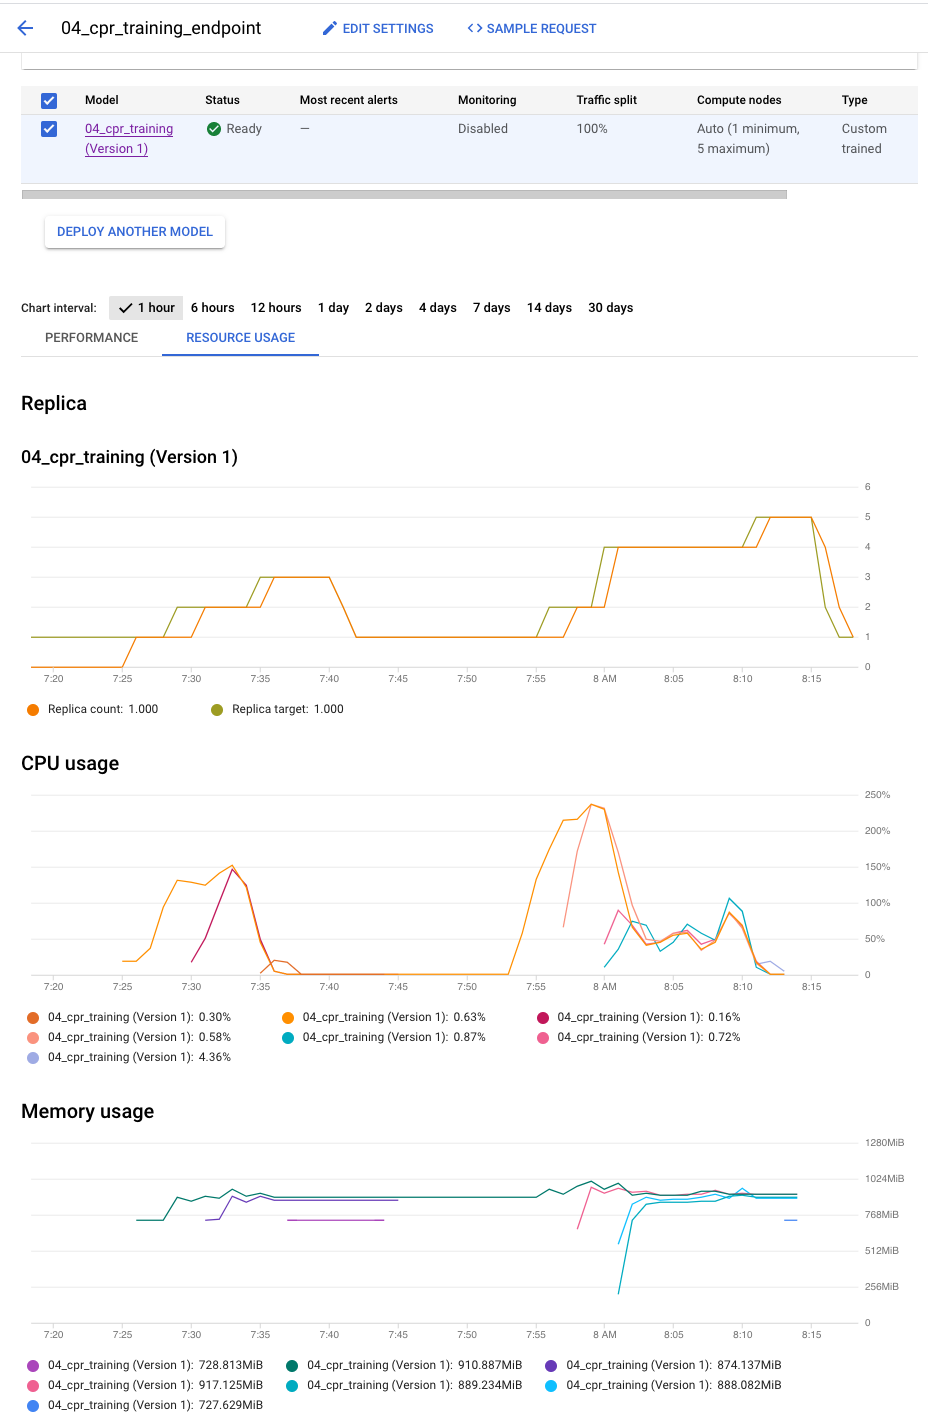

In [108]:
endpoint.delete(force = True)

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/850841679991668736
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/850841679991668736/operations/6291051285231697920
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/850841679991668736
Deleting Endpoint : projects/1026793852137/locations/us-central1/endpoints/850841679991668736
Delete Endpoint  backing LRO: projects/1026793852137/locations/us-central1/operations/3985208276018003968
Endpoint deleted. . Resource name: projects/1026793852137/locations/us-central1/endpoints/850841679991668736


In [109]:
model.delete()

Deleting Model : projects/1026793852137/locations/us-central1/models/373783375908962304
Delete Model  backing LRO: projects/1026793852137/locations/us-central1/operations/3386229525577728000
Model deleted. . Resource name: projects/1026793852137/locations/us-central1/models/373783375908962304
